# Datasets comparison between CAMS and TROPOMI (L3)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import subprocess # Important for GOME-2 and TROPOMI L3
import gzip # Important for TROPOMI L3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L3'
apply_kernels = False

# Define search period
start_date = '2019-01-01'
end_date = '2019-12-31'

# Define extent
area_name = 'Europe'
lon_min = -25
lon_max = 45
lat_min = 30
lat_max = 70

# Define resolution (Unique: 0.125x.0.125)
lat_res = 0.125
lon_res = 0.125

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_MW, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12')
SEARCH BOUNDING BOX
Latitudes: from 30 to 70
Longitudes: from -25 to 45


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'single', CAMS_UID = None, CAMS_key = None)

2022-02-07 19:39:47,960 INFO Welcome to the CDS
2022-02-07 19:39:47,961 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly


The file does not exist, it will be downloaded.


2022-02-07 19:39:48,058 INFO Request is completed
2022-02-07 19:39:48,058 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data9/adaptor.mars.internal-1643482221.9678106-32140-13-8c7bfaaf-d47a-41a5-9f22-f8149a179d25.grib to /home/alba/adc-toolbox/data/cams/NO2/CAMS_REANALYSIS_NO2_TC_2019-01-01_2019-12-31_Europe.grib (180K)
2022-02-07 19:39:48,162 INFO Download rate 1.7M/s


In [8]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 12)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -25.0 -24.25 -23.5 ... 43.25 44.0 44.75
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-02-07T19:39 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_MW, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


### Get CAMS levels (total or tropospheric)

In [11]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be directly compared to the tropospheric sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 12)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
    surface     float64 0.0
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -25.0 -24.25 -23.5 ... 43.25 44.0 44.75
    valid_time  (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Data variables:
    component   (time, latitude, longitude) float32 1.028e+15 ... 8.458e+14
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-02-07T19:39 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Download and read data as xarray

In [12]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
TROPOMI_L3_NO2_COLUMN_201901.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201902.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201903.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201904.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201905.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201906.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201907.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201908.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201909.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201910.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201911.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_201912.asc.gz was downloaded.


In [13]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:        (latitude: 1440, longitude: 2880, time: 12)
Coordinates:
  * longitude      (longitude) float64 -179.9 -179.8 -179.7 ... 179.8 179.9
  * latitude       (latitude) float64 -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * time           (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Data variables:
    sensor_column  (longitude, latitude, time) float64 2e+13 -2e+13 ... nan nan

## 4. Match data

In [14]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2019-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2019-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

,latitude,longitude,time,sensor_column,model_column
0,29.9375,-25.0625,2019-01-01,4.800000e+14,1.027839e+15
1,29.9375,-24.9375,2019-01-01,4.700000e+14,1.027839e+15
2,29.9375,-24.8125,2019-01-01,5.000000e+14,1.027839e+15
3,29.9375,-24.6875,2019-01-01,5.200000e+14,1.027839e+15
4,29.9375,-24.5625,2019-01-01,4.500000e+14,1.037693e+15
...,...,...,...,...,...
180076,69.9375,44.4375,2019-12-01,NaN,8.457677e+14
180077,69.9375,44.5625,2019-12-01,NaN,8.457677e+14
180078,69.9375,44.6875,2019-12-01,NaN,8.457677e+14
180079,69.9375,44.8125,2019-12-01,NaN,8.457677e+14


## 5. Merge data and calculate difference

In [15]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
29.9375  -25.0625  2019-01-01  1.027839e+15   4.800000e+14  5.478395e+14   
         -24.9375  2019-01-01  1.027839e+15   4.700000e+14  5.578395e+14   
         -24.8125  2019-01-01  1.027839e+15   5.000000e+14  5.278395e+14   
         -24.6875  2019-01-01  1.027839e+15   5.200000e+14  5.078395e+14   
         -24.5625  2019-01-01  1.037693e+15   4.500000e+14  5.876935e+14   
...                                     ...            ...           ...   
69.9375   44.4375  2019-12-01  8.457677e+14            NaN           NaN   
          44.5625  2019-12-01  8.457677e+14            NaN           NaN   
          44.6875  2019-12-01  8.457677e+14            NaN           NaN   
          44.8125  2019-12-01  8.457677e+14            NaN           NaN   
          44.9375  2019-12-01  8.457677e+14            NaN           NaN   

                               relative_difference  
latitude longitude time                             
29.9375  -25.0625  2019-01-01             1.141332  
         -24.9375  2019-01-01             1.186893  
         -24.8125  2019-01-01             1.055679  
         -24.6875  2019-01-01             0.976614  
         -24.5625  2019-01-01             1.305986  
...                                            ...  
69.9375   44.4375  2019-12-01                  NaN  
          44.5625  2019-12-01                  NaN  
          44.6875  2019-12-01                  NaN  
          44.8125  2019-12-01                  NaN  
          44.9375  2019-12-01                  NaN  

[2160972 rows x 4 columns]

In [16]:
descr_stats_table = merge_df.describe()
descr_stats_table

,model_column,sensor_column,difference,relative_difference
count,2.160972e+06,2.048332e+06,2.048332e+06,2.048332e+06
mean,2.773445e+15,1.115421e+15,1.713381e+15,inf
std,1.589898e+15,9.068409e+14,1.048193e+15,NaN
min,3.447121e+14,-2.000000e+15,-1.723362e+16,-1.108015e+03
25%,1.587348e+15,5.800000e+14,1.012374e+15,1.224639e+00
50%,2.439502e+15,9.100000e+14,1.465228e+15,1.647724e+00
75%,3.550572e+15,1.360000e+15,2.153440e+15,2.247648e+00
max,1.835418e+16,2.525000e+16,1.583919e+16,inf


## 6. Show comparison plots

### Select plot dates

In [17]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12']


### Select plot extent

In [18]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and TROPOMI total columns

Frame length between -25 and 45 should be one of these options: [1, 2, 5, 7, 10, 14, 35, 70]
Frame length between 30 and 70 should be one of these options: [1, 2, 4, 5, 8, 10, 20, 40]


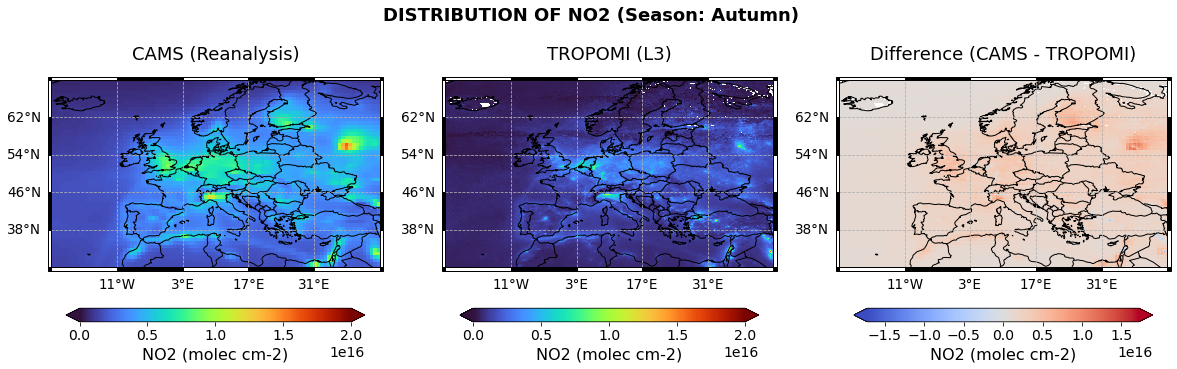

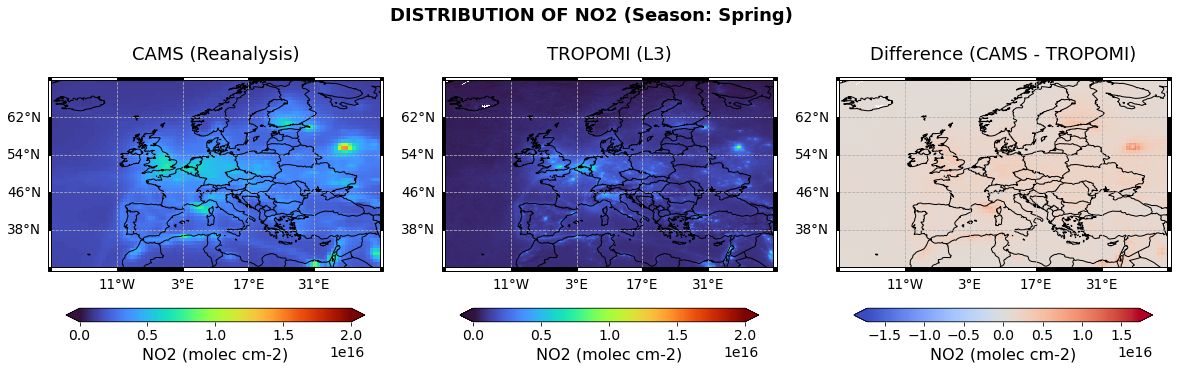

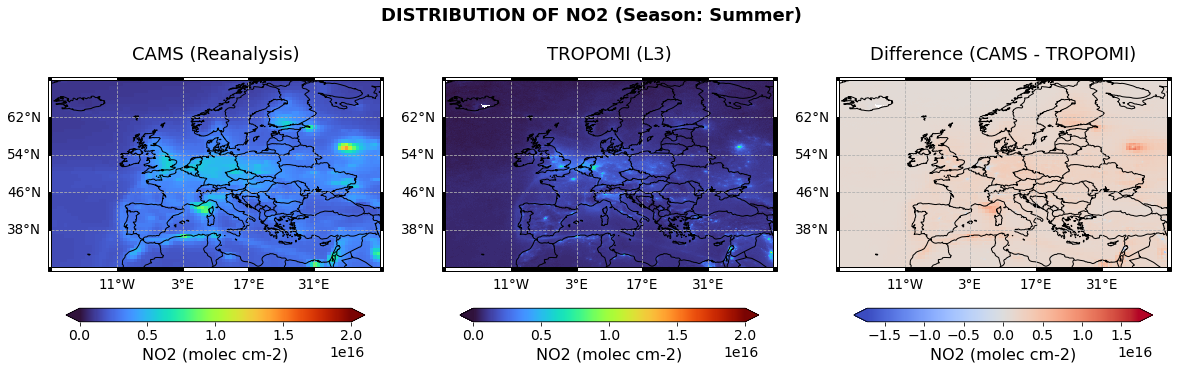

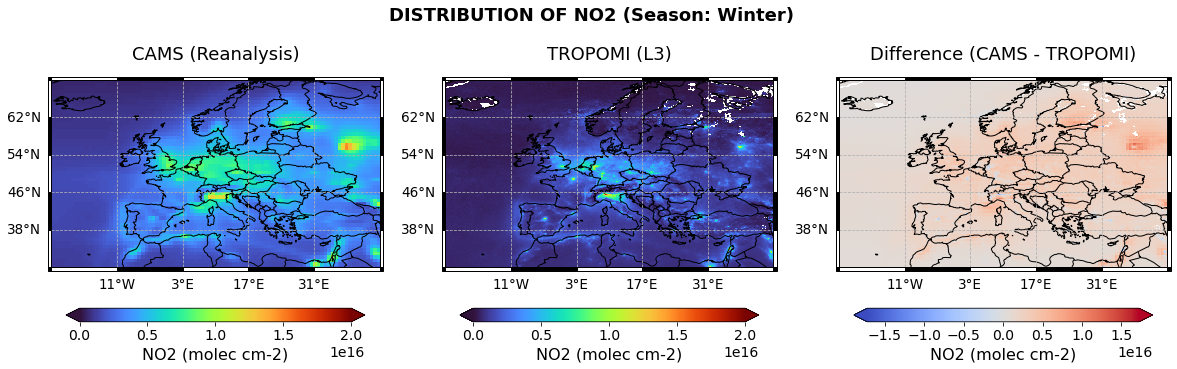

In [19]:
# Choose distribution (aggregated, individual, seasonal or animated)
plot_type = 'seasonal'

# Define range (original, equal, centered or manual)
range_type = 'manual'
vmin_manual, vmax_manual = 0, 2*10**16
vmin_manual_diff, vmax_manual_diff = None, None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 14
height_lat = 8

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1, 
                          model_type, sensor_type, range_type, plot_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual,
                          vmin_manual_diff, vmax_manual_diff,
                          bbox_list = None, coords_list = None, regions_names = None)

## 7. Retrieve nearest values to specific coordinates

model_column  \
region lat_search lon_search latitude longitude time                       
London 51.5072    -0.1276    51.5625  -0.1875   2019-01-01  9.202687e+15   
                                                2019-02-01  1.016903e+16   
                                                2019-03-01  7.898637e+15   
                                                2019-04-01  8.566063e+15   
                                                2019-05-01  7.218684e+15   
                                                2019-06-01  6.010311e+15   
                                                2019-07-01  5.737015e+15   
                                                2019-08-01  5.504132e+15   
                                                2019-09-01  6.790573e+15   
                                                2019-10-01  8.228909e+15   
                                                2019-11-01  1.038612e+16   
                                                2019-12-01  9.175254e+15   

                                                            sensor_column  \
region lat_search lon_search latitude longitude time                        
London 51.5072    -0.1276    51.5625  -0.1875   2019-01-01   8.570000e+15   
                                                2019-02-01   1.271000e+16   
                                                2019-03-01   5.570000e+15   
                                                2019-04-01   1.051000e+16   
                                                2019-05-01   7.010000e+15   
                                                2019-06-01   5.400000e+15   
                                                2019-07-01   7.410000e+15   
                                                2019-08-01   7.460000e+15   
                                                2019-09-01   6.940000e+15   
                                                2019-10-01   6.000000e+15   
                                                2019-11-01   8.800000e+15   
                                                2019-12-01   6.160000e+15   

                                                              difference  \
region lat_search lon_search latitude longitude time                       
London 51.5072    -0.1276    51.5625  -0.1875   2019-01-01  6.326868e+14   
                                                2019-02-01 -2.540973e+15   
                                                2019-03-01  2.328637e+15   
                                                2019-04-01 -1.943937e+15   
                                                2019-05-01  2.086836e+14   
                                                2019-06-01  6.103107e+14   
                                                2019-07-01 -1.672985e+15   
                                                2019-08-01 -1.955868e+15   
                                                2019-09-01 -1.494275e+14   
                                                2019-10-01  2.228909e+15   
                                                2019-11-01  1.586119e+15   
                                                2019-12-01  3.015254e+15   

                                                            relative_difference  
region lat_search lon_search latitude longitude time                             
London 51.5072    -0.1276    51.5625  -0.1875   2019-01-01             0.073826  
                                                2019-02-01            -0.199919  
                                                2019-03-01             0.418068  
                                                2019-04-01            -0.184961  
                                                2019-05-01             0.029769  
                                                2019-06-01             0.113020  
                                                2019-07-01            -0.225774  
                                                2019-08-01            -0.262181  
                               

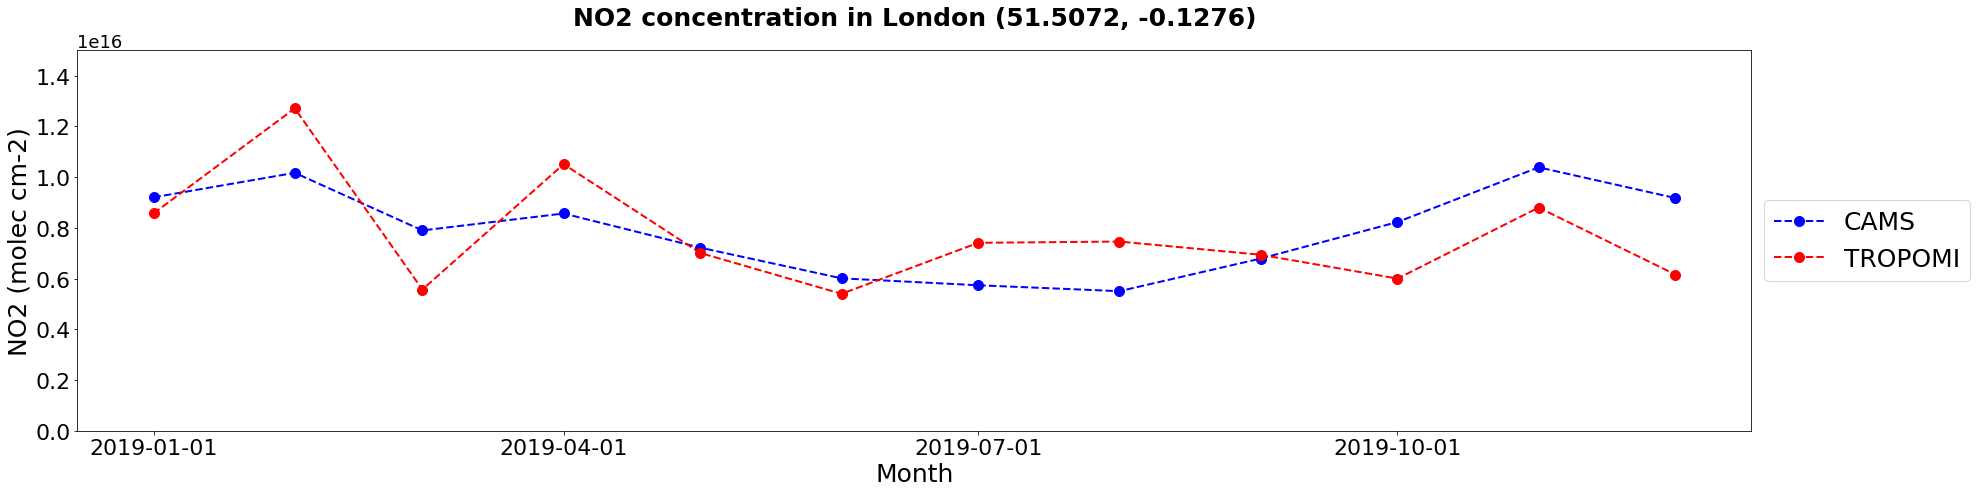

In [20]:
regions_names = ('London')
coords_list = (51.5072, -0.1276)
ymin = 0
ymax = 1.5*10**16
xticks = plot_dates[0::3]

timeseries_table = timeseries(merge_df, component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

## 8. Monthly annual cycle

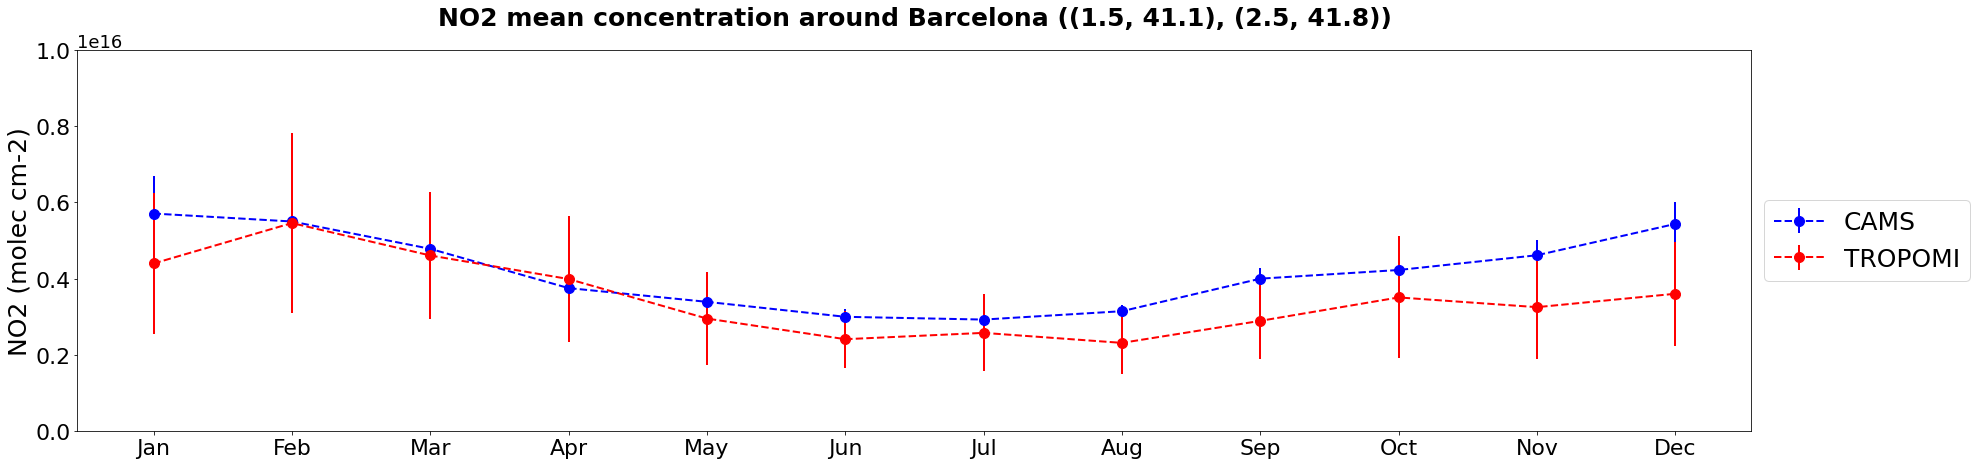

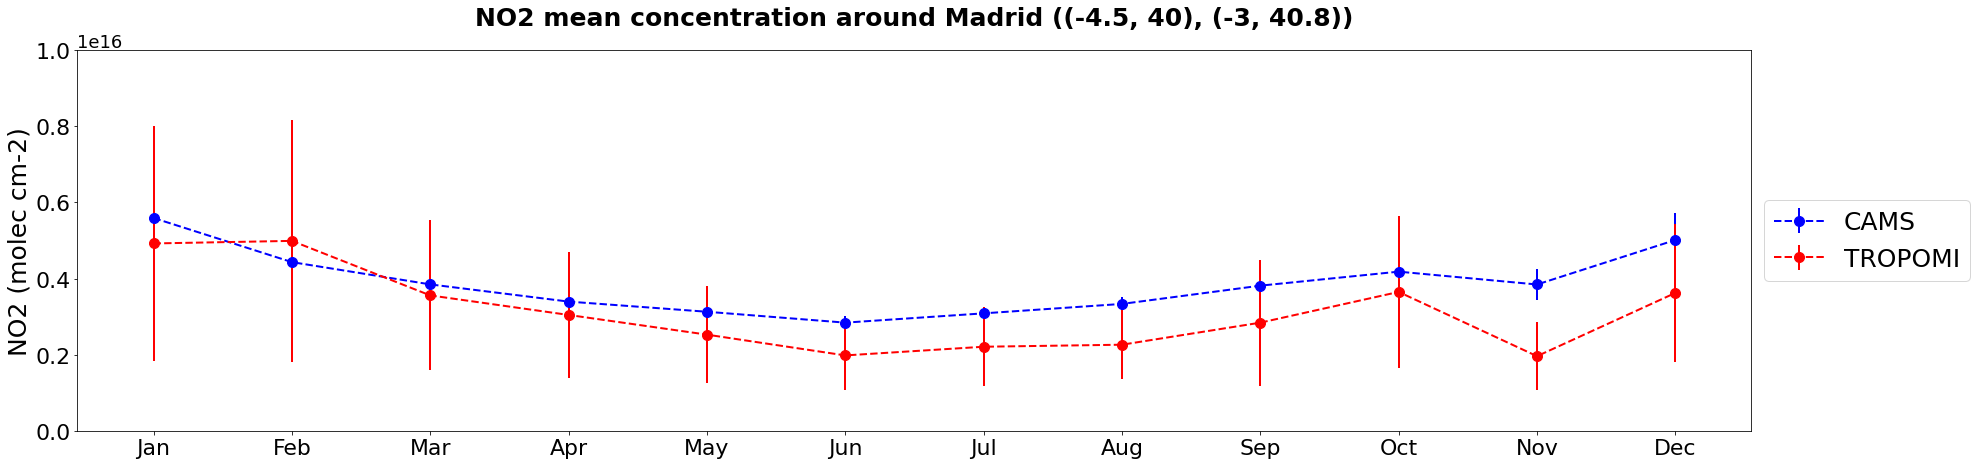

,location,month,model mean,model std,sensor mean,sensor std
0,Barcelona,1,5.709719e+15,9.903379e+14,4.396750e+15,1.858612e+15
1,Barcelona,2,5.500717e+15,6.515277e+14,5.459250e+15,2.367951e+15
2,Barcelona,3,4.782443e+15,4.062999e+14,4.607500e+15,1.666825e+15
3,Barcelona,4,3.750211e+15,2.386282e+14,3.988500e+15,1.651741e+15
4,Barcelona,5,3.389000e+15,2.273391e+14,2.949500e+15,1.228524e+15
5,Barcelona,6,2.995888e+15,1.973119e+14,2.407250e+15,7.482937e+14
6,Barcelona,7,2.923126e+15,1.226961e+14,2.573500e+15,1.010931e+15
7,Barcelona,8,3.143131e+15,1.738395e+14,2.310500e+15,8.101787e+14
8,Barcelona,9,3.998153e+15,2.717950e+14,2.889500e+15,9.945053e+14
9,Barcelona,10,4.225723e+15,3.054375e+14,3.505000e+15,1.603921e+15


In [21]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3)
ymin = 0
ymax = 1*10**16

monthly_annual_cycle_table = monthly_annual_cycle(merge_df, component_nom, sensor, model, units, 
                                                  ymin, ymax, regions_names, bbox_list)
monthly_annual_cycle_table

## 9. Trends

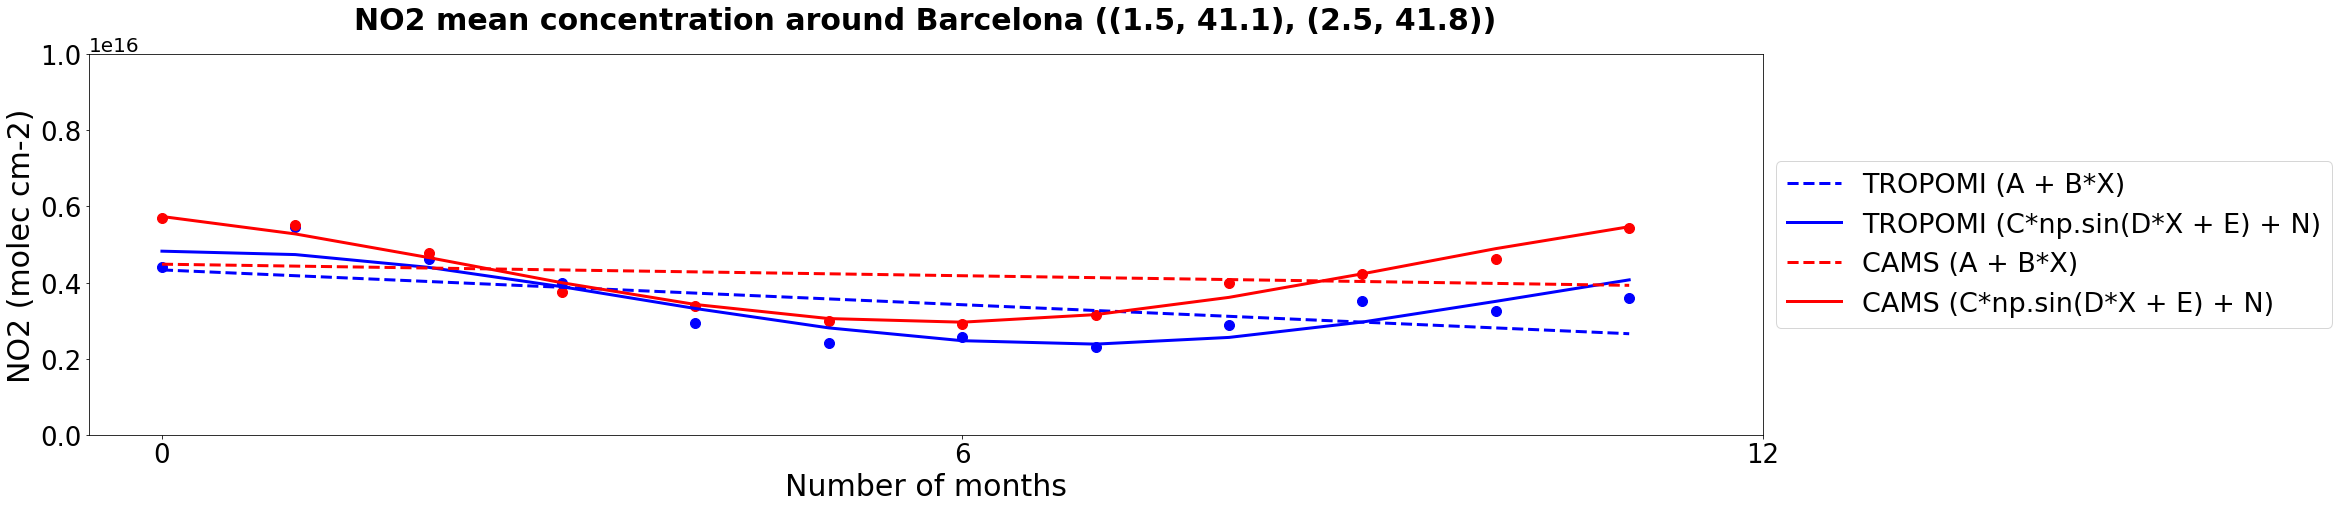

sensor data at Madrid cannot be fitted with a sinusoidal model to account for the seasonality, consider working with a larger dataset.
model data at Madrid cannot be fitted with a sinusoidal model to account for the seasonality, consider working with a larger dataset.


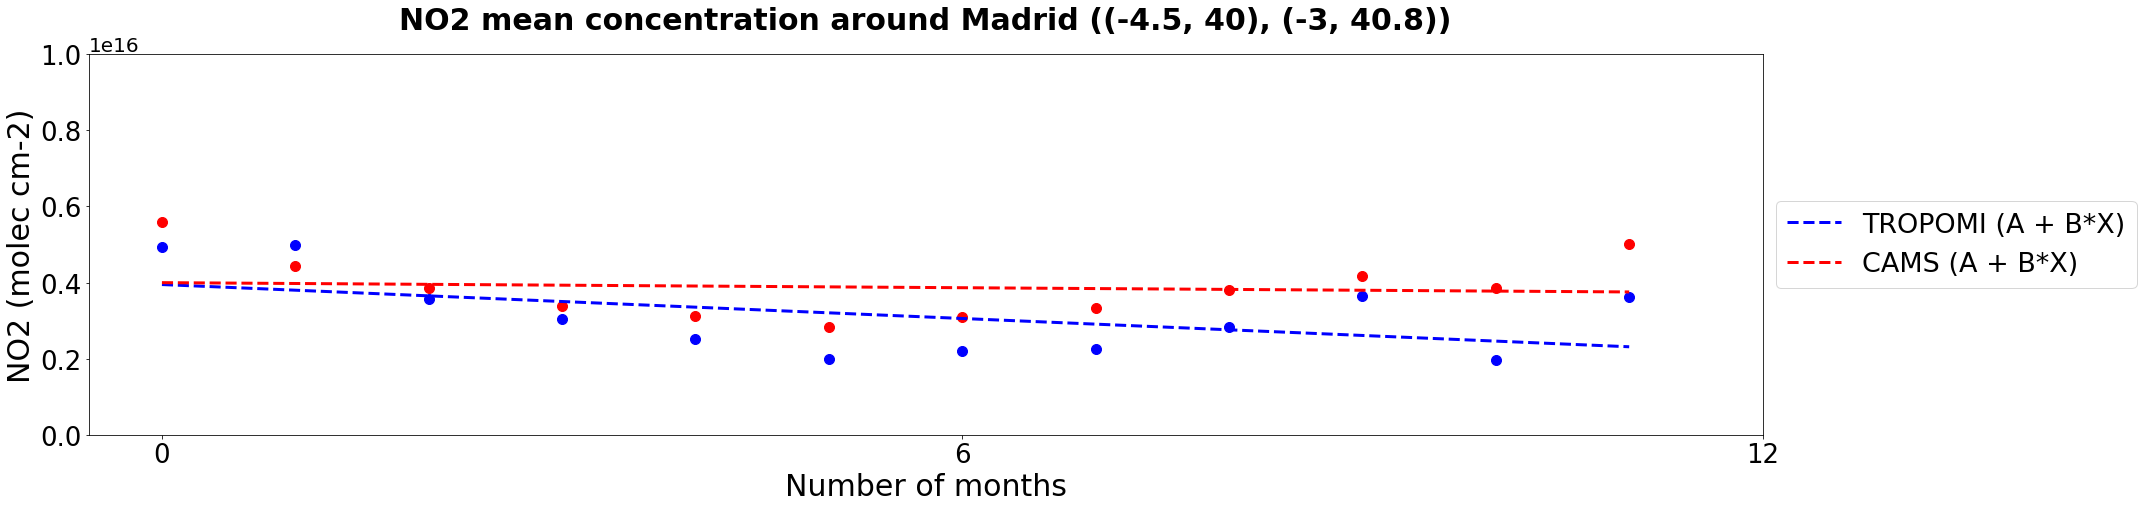

,Location,Source,Rate (molec cm-2 y-1),Rate (% y-1),A,B,C,D,E,N,Linear R2,Linear RMSE,Linear MSE,Sinusoidal R2,Sinusoidal RMSE,Sinusoidal MSE
0,Barcelona,Sensor,-1.829413e+15,-42.217401,4.333314e+15,-1.524510e+14,1.225113e+15,0.471098,1.492495,3.604439e+15,0.321919,7.637931e+14,5.833799e+29,0.829249,3.832806e+14,1.469040e+29
1,Barcelona,Model,-6.063591e+14,-13.523798,4.483645e+15,-5.052992e+13,1.497282e+15,0.447218,2.109649,4.452121e+15,0.032865,9.462432e+14,8.953763e+29,0.967577,1.732552e+14,3.001738e+28
0,Madrid,Sensor,-1.784108e+15,-45.180845,3.948816e+15,-1.486757e+14,NaN,NaN,NaN,NaN,0.260828,8.639989e+14,7.464940e+29,NaN,NaN,NaN
1,Madrid,Model,-2.666366e+14,-6.668299,3.998569e+15,-2.221972e+13,NaN,NaN,NaN,NaN,0.009506,7.829505e+14,6.130115e+29,NaN,NaN,NaN


In [22]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3)
ymin = 0
ymax = 1*10**16
sensor_break_date = None # None or date as a string
model_break_date = None # None or date as a string

trends_table = trends(merge_df, component_nom, sensor, model, units, ymin, ymax, 
                      plot_dates, regions_names, bbox_list, sensor_break_date, model_break_date)
trends_table

In [23]:
# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['RdYlGn_r', 'RdYlGn_r', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 5
height_lat = 3

# Define break dates (None or both the same)
sensor_break_date = None # None or date as a string
model_break_date = None # None or date as a string

# Define range
vmax_manual_rate_units, vmin_manual_rate_units = 4*10**14, -4*10**14
vmax_manual_rate_diff_units, vmin_manual_rate_diff_units = 6*10**14, -6*10**14
vmax_manual_rate_100, vmin_manual_rate_100 = 15, -15
vmax_manual_rate_diff_100, vmin_manual_rate_diff_100 = 20, -20

bbox_trends_table = visualize_bbox_trends(merge_df, component_nom, sensor, model, units, plot_dates, 
                                          sensor_break_date, model_break_date, 20, 1.05,
                                          vmin_manual_rate_units, vmax_manual_rate_units, 
                                          vmin_manual_rate_100, vmax_manual_rate_100,
                                          vmin_manual_rate_diff_units, vmax_manual_rate_diff_units, 
                                          vmin_manual_rate_diff_100, vmax_manual_rate_diff_100,
                                          width_lon, height_lat, 
                                          bbox_list = None, coords_list = None, regions_names = None)

Frame length between -25 and 45 should be one of these options: [1, 2, 5, 7, 10, 14, 35, 70]
Frame length between 30 and 70 should be one of these options: [1, 2, 4, 5, 8, 10, 20, 40]


## 10. Scatter plots by bbox

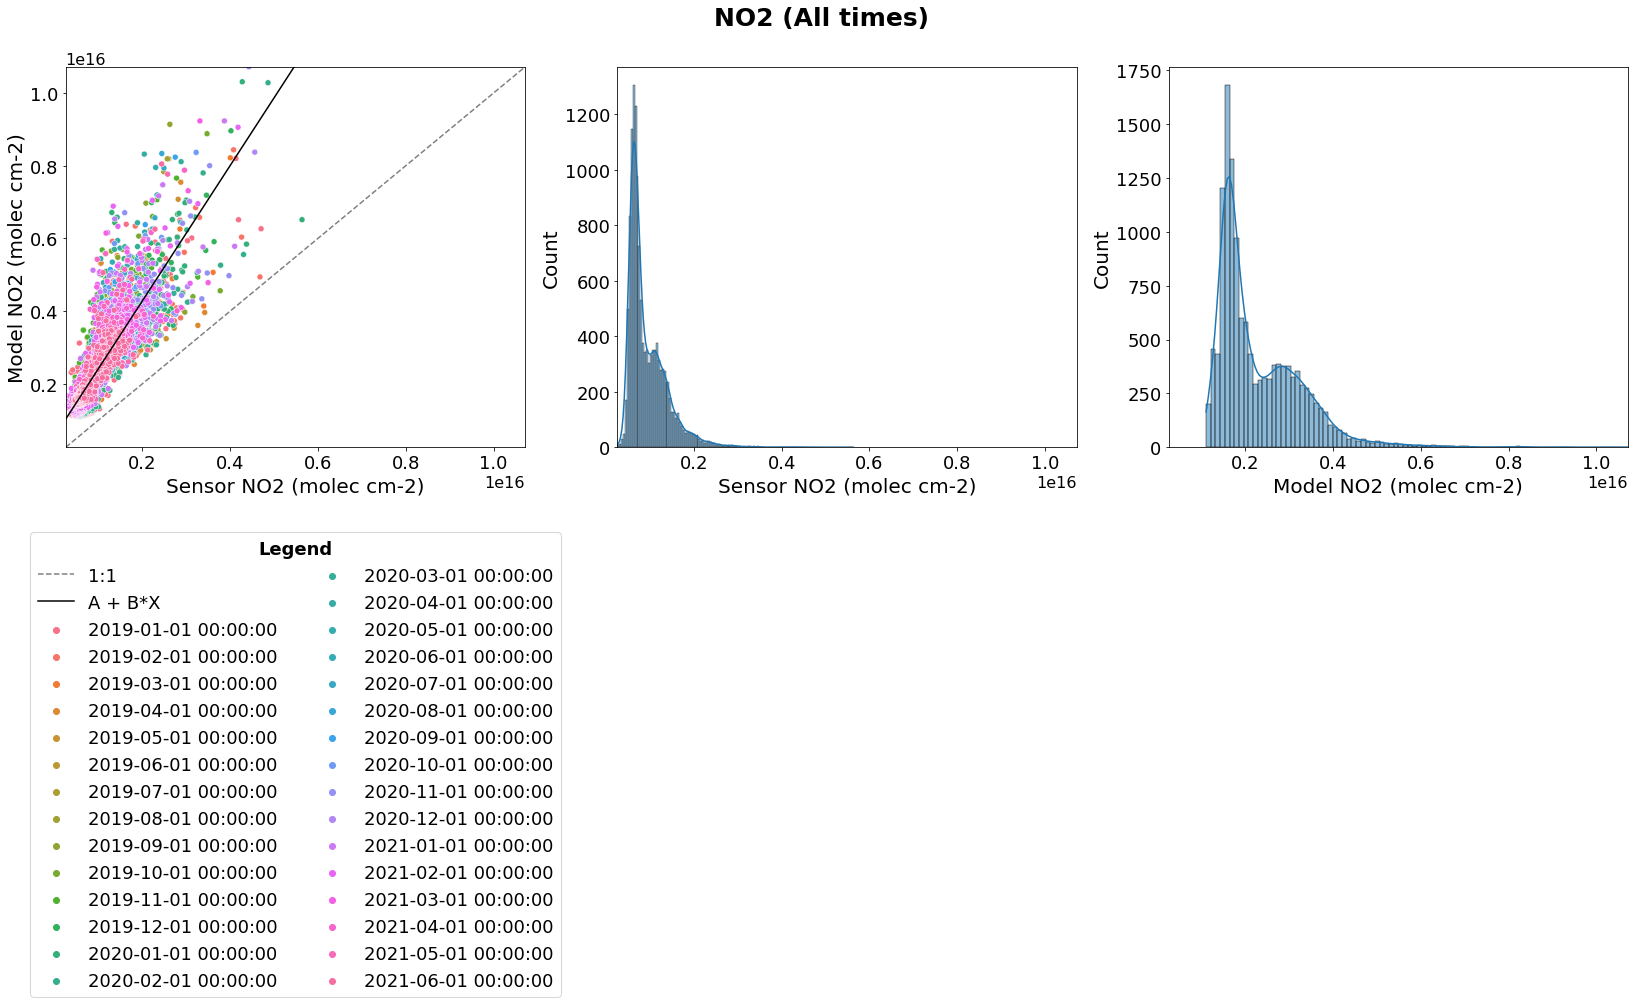

,Period,Location,A,B,R2,RMSE,MSE
0,"[2019-01-01T00:00:00.000000000, 2019-02-01T00:...","((-20, 27), (5, 45))",1.861987,5.576992e+14,0.769749,4.631823e+14,2.145379e+29


In [ ]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 11. Scatter plots by season

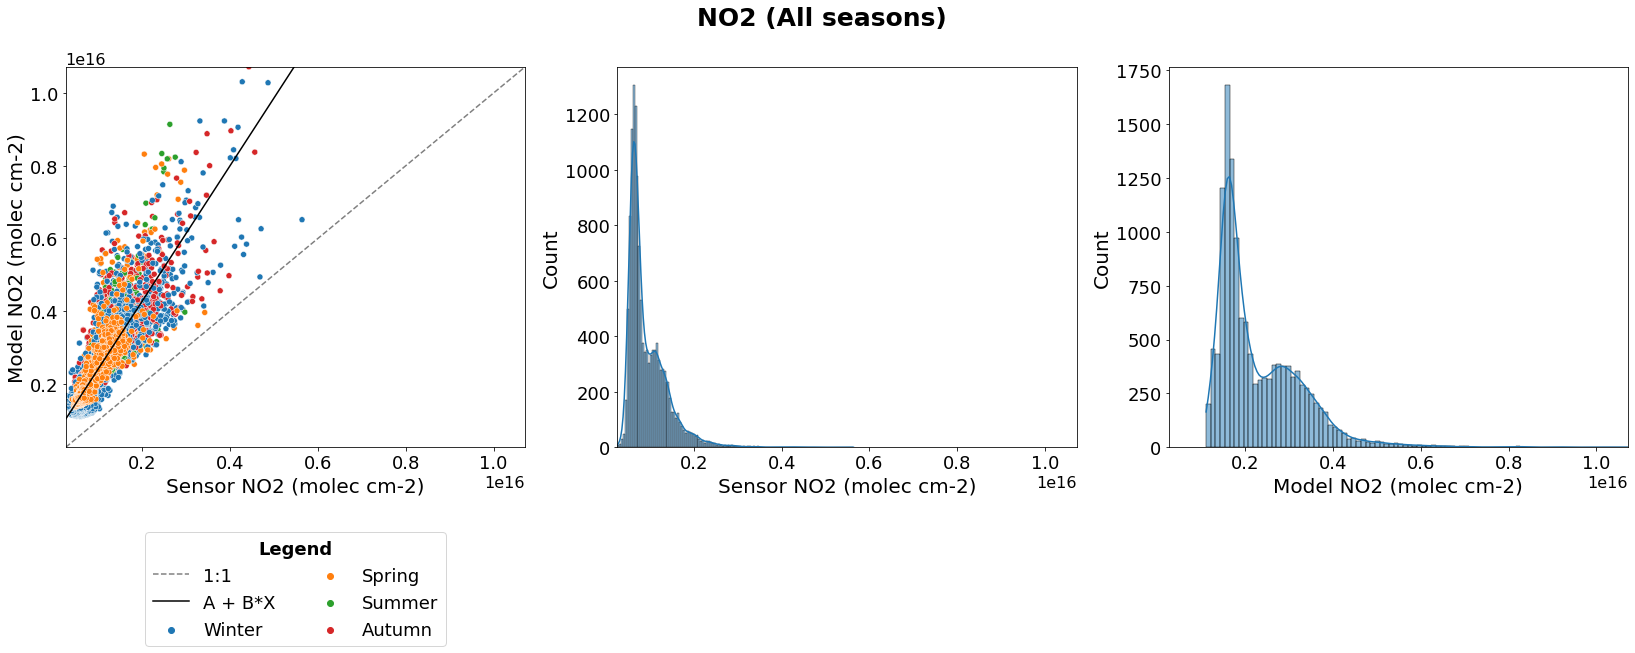

,Period,Location,A,B,R2,RMSE,MSE
0,"[Autumn, Spring, Summer, Winter]","((-20, 27), (5, 45))",1.861987,5.576992e+14,0.769749,4.631823e+14,2.145379e+29


In [ ]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 12. Scatter plots by country (Google API required!)

In [ ]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, 
             lim_min, lim_max, plot_countries)
summary 
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary \n"